## Setup

In [ ]:
import sys
import os
import logging
import yaml
import torch
from google.colab import drive, files

drive.mount('/content/drive')

# Set directories and configuration file
PROJECT_DIR = "/content/drive/MyDrive/pfp"
CONFIG_FILE = f"{PROJECT_DIR}/config.yaml"
SRC_DIR = f"{PROJECT_DIR}/src"
DATA_DIR = f"{PROJECT_DIR}/data"
DATA_TRAIN_DIR = f"{DATA_DIR}/train"
DATA_TEST_DIR = f"{DATA_DIR}/test"
DATA_CUSTOM_DIR = f"{DATA_DIR}/custom"
DATA_CUSTOM_TRAIN_DIR = f"{DATA_CUSTOM_DIR}/train"
DATA_CUSTOM_TRAIN_BLAST_DIR = f"{DATA_CUSTOM_TRAIN_DIR}/train_blast"
DATA_CUSTOM_TEST_DIR = f"{DATA_CUSTOM_DIR}/test"
LOGS_DIR = f"{PROJECT_DIR}/logs"
MODELS_DIR = f"{PROJECT_DIR}/models"
RESULTS_DIR = f"{PROJECT_DIR}/results"
EVALUATIONS_DIR = f"{RESULTS_DIR}/evaluations"

# Add the src directory to the Python path
sys.path.append(SRC_DIR)

# Choose device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

# Load the configuration data from the YAML file
with open(CONFIG_FILE, 'r') as f:
    config_data = yaml.safe_load(f)

Mounted at /content/drive
Device: cuda


### File paths

In [ ]:
# Set BLAST file paths
TRAIN_BLAST_FILE = config_data['paths']['train_blast']
TEST_BLAST_FILE = config_data['paths']['test_blast']

### Libraries

In [ ]:
# Python
import pandas as pd
import tensorflow as tf
import numpy as np
import keras
import importlib
import h5py
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

# Custom
import data_preprocessing as dp
import exploratory_data_analysis as eda
import model_training as mt
import blast_based_scores as bbs
import ensemble
import utils

### MLP Hyperparameters

In [ ]:
# Set MLP hyperparameters
SEED = config_data['parameters']['RANDOM_SEED']
EPOCHS = config_data['parameters']['EPOCHS']
BATCH_SIZE = config_data['parameters']['BATCH_SIZE']
NUM_HIDDEN = {}
SIZE_HIDDEN = {}
ACTIVATION = {}
ALPHA = {}
LR = {}
DROPOUT = {}
MODEL_TYPE = {}
model_types = ['mf', 'bp', 'cc']
for model in model_types:
    NUM_HIDDEN[model] = config_data['parameters']['NUM_HIDDEN'][model]
    SIZE_HIDDEN[model] = config_data['parameters']['SIZE_HIDDEN'][model]
    ACTIVATION[model] = config_data['parameters']['ACTIVATION'][model]
    ALPHA[model] = config_data['parameters']['ALPHA'][model]
    LR[model] = config_data['parameters']['LR'][model]
    DROPOUT[model] = config_data['parameters']['DROPOUT'][model]
    MODEL_TYPE[model] = config_data['parameters']['MODEL_TYPE'][model]

In [ ]:
# Set seed
utils.set_random_seed(SEED)

Random seed set as 42


## Load data

### Original

In [ ]:
# Load original train set
train_set, train_embeddings, train_ids = dp.load_original_data(config_data, test=False)
# Load original test set
test_embeddings, test_ids = dp.load_original_data(config_data, test=True)

In [ ]:
# Load test BLAST results
test_blast = pd.read_csv(TEST_BLAST_FILE, sep='\t')

In [ ]:
# Check that the training set and the training embeddings are in the same order
print(f"Are the training set and the T5 embeddings in the same oder?")
print(f"{train_set['protein_id'].unique().tolist() == list(train_ids)}")

Are the training set and the T5 embeddings in the same oder?
True


### Custom

In [ ]:
# Load custom train data
custom_train_set, custom_train_embeddings, custom_train_ids = dp.load_custom_data(config_data, test=False)
# Load custom test data
custom_test_set, custom_test_embeddings, custom_test_ids = dp.load_custom_data(config_data, test=True)

In [ ]:
# Load train BLAST results
train_blast = pd.read_csv(TRAIN_BLAST_FILE, sep='\t')

In [ ]:
# Ensure datasets don't overlap
intersection = set(custom_train_ids) & set(custom_test_ids)
print("Train and test set don't overlap.") if not intersection else print("Train and test set overlap.")

# Check protein counts
print(f"Number of proteins in the training set: {len(custom_train_set['protein_id'].unique())}")
print(f"Number of proteins in the custom test set: {len(custom_test_ids)}")
print(f"Total number of proteins: {len(custom_train_set['protein_id'].unique()) + len(custom_test_ids)}")

Train and test set don't overlap.
Number of proteins in the training set: 122969
Number of proteins in the custom test set: 1000
Total number of proteins: 123969


## Exploratory Data Analysis

### Original data

In [ ]:
# Visualize training set structure
train_set.head()

,protein_id,aspect,go_term
3668490,A0A009IHW8,biological_process,GO:0009056
3668508,A0A009IHW8,biological_process,GO:0006139
3668501,A0A009IHW8,biological_process,GO:0009987
3668507,A0A009IHW8,biological_process,GO:0019637
3668506,A0A009IHW8,biological_process,GO:1901575


In [ ]:
# Split training set by aspect and extract the corresponding protein IDs
train_mf, train_bp, train_cc = dp.split_by_aspect(train_set)
train_mf_ids = dp.get_protein_ids(train_mf)
train_bp_ids = dp.get_protein_ids(train_bp)
train_cc_ids = dp.get_protein_ids(train_cc)

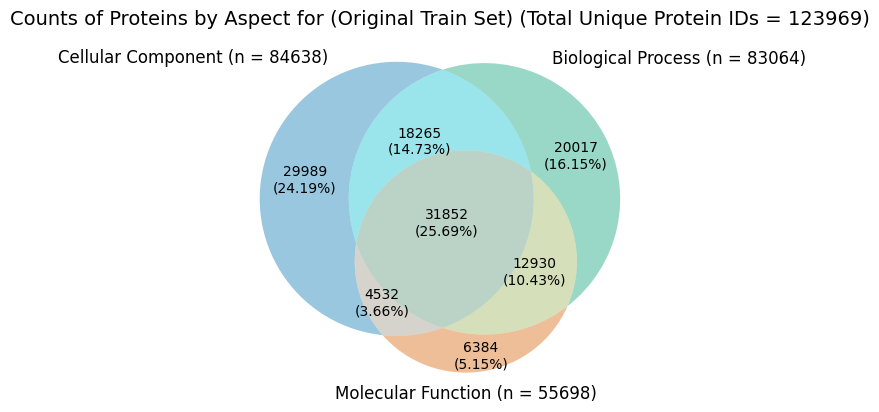

In [ ]:
# Plot proteins by aspect
venn_aspect = eda.create_venn_diagram(train_cc_ids, train_mf_ids, train_bp_ids, custom=False, test_set=False)

In [ ]:
# Plot original training set aspect and GO terms distribution
barplot_go_train = eda.plot_go_by_aspect(train_set, custom=False, test_set=False)
barplot_go_mf = eda.plot_n_go(train_mf, 50, aspect='Molecular Function', custom=False, test_set=False)
barplot_go_cc = eda.plot_n_go(train_cc, 50, aspect='Cellular Component', custom=False, test_set=False)
barplot_go_bp = eda.plot_n_go(train_bp, 50, aspect='Biological Process', custom=False, test_set=False)

### Custom data

In [ ]:
# Split custom training set and custom test set into aspect datasets
custom_train_mf, custom_train_bp, custom_train_cc = dp.split_by_aspect(custom_train_set)
custom_test_mf, custom_test_bp, custom_test_cc = dp.split_by_aspect(custom_test_set)

In [ ]:
# Plot custom training set aspect and GO terms distribution
barplot_go_updated_train = eda.plot_go_by_aspect(custom_train_set, custom=True, test_set=False)
barplot_go_updated_mf = eda.plot_n_go(custom_train_mf, 50, aspect='Molecular Function', custom=True, test_set=False)
barplot_go_updated_cc = eda.plot_n_go(custom_train_cc, 50, aspect='Cellular Component', custom=True, test_set=False)
barplot_go_updated_bp = eda.plot_n_go(custom_train_bp, 50, aspect='Biological Process', custom=True, test_set=False)

In [ ]:
# Plot custom test set aspect and GO terms distribution
barplot_go_custom_test = eda.plot_go_by_aspect(custom_test_set, custom=True, test_set=True)
barplot_go_test_mf = eda.plot_n_go(custom_test_mf, 50, aspect='Molecular Function', custom=True, test_set=True)
barplot_go_test_cc = eda.plot_n_go(custom_test_cc, 50, aspect='Cellular Component', custom=True, test_set=True)
barplot_go_test_bp = eda.plot_n_go(custom_test_bp, 50, aspect='Biological Process', custom=True, test_set=True)

## MLP

#### Data Preprocessing

In [ ]:
# Prepare input features and labels for each custom aspect training set
x_mf, y_bin_mf, classes_mf = dp.prepare_features_and_labels('molecular_function', custom_train_mf, custom_train_embeddings, custom_train_ids)
x_bp, y_bin_bp, classes_bp = dp.prepare_features_and_labels('biological_process', custom_train_bp, custom_train_embeddings, custom_train_ids)
x_cc, y_bin_cc, classes_cc = dp.prepare_features_and_labels('cellular_component', custom_train_cc, custom_train_embeddings, custom_train_ids)

Preparing molecular_function features and labels
Preparing biological_process features and labels
Preparing cellular_component features and labels


In [ ]:
# Split each dataset into training and validation sets
X_train_mf, X_val_mf, y_train_mf, y_val_mf = train_test_split(x_mf, y_bin_mf, test_size=0.2, random_state=SEED, shuffle=True)
X_train_bp, X_val_bp, y_train_bp, y_val_bp = train_test_split(x_bp, y_bin_bp, test_size=0.2, random_state=SEED, shuffle=True)
X_train_cc, X_val_cc, y_train_cc, y_val_cc = train_test_split(x_cc, y_bin_cc, test_size=0.2, random_state=SEED, shuffle=True)

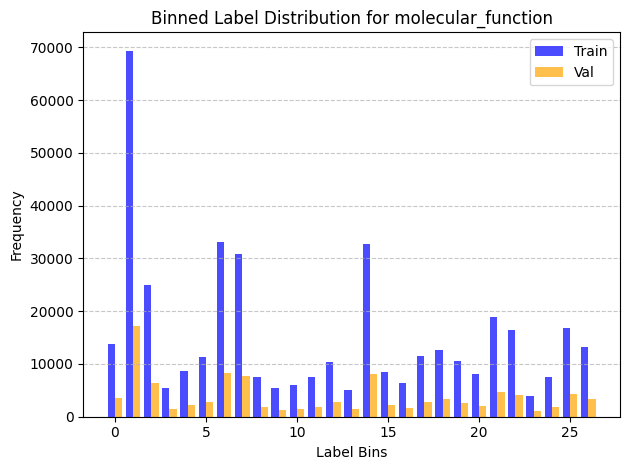

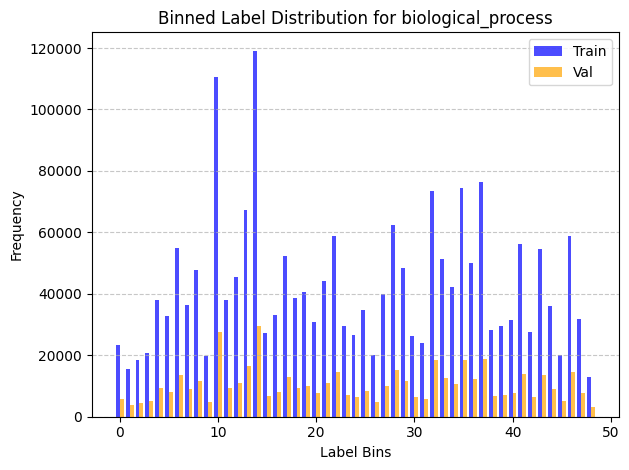

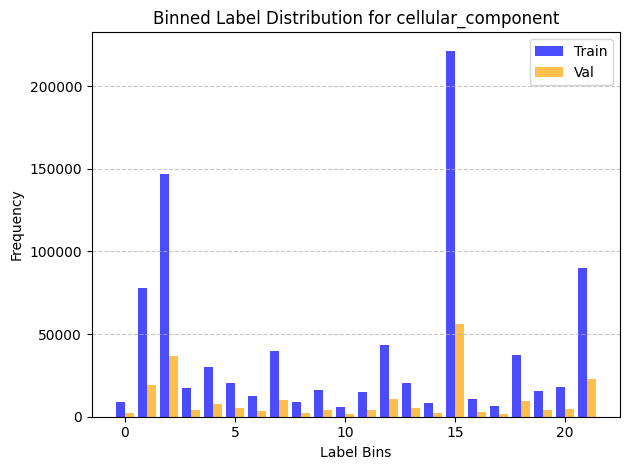

In [ ]:
# Plot training and validation label distribution
mf_train_val_dist = mt.plot_label_distribution(y_train_mf, y_val_mf, aspect='molecular_function')
bp_train_val_dist = mt.plot_label_distribution(y_train_bp, y_val_bp, aspect='biological_process')
cc_train_val_dist = mt.plot_label_distribution(y_train_cc, y_val_cc, aspect='cellular_component')

#### Training

##### molecular_function

In [ ]:
# Model summary
mf_mlp = mt.build_model(X_train_mf.shape[1], y_train_mf.shape[1], 'molecular_function', MODEL_TYPE['mf'], NUM_HIDDEN['mf'], SIZE_HIDDEN['mf'], ACTIVATION['mf'], DROPOUT['mf'], ALPHA['mf'], set_seed=SEED)
mf_mlp.summary()

Model: "molecular_function_fixed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_0_batch_norm                   │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_0_dropout (Dropout)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_dense (Dense)                │ (None, 300)                 │         307,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_dropout (Dropout)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_dense (Dense)                │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_dropout (Dropout)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_dense (Dense)                │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_dropout (Dropout)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_dense (Dense)                │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_dropout (Dropout)            │ (None, 300)                 │              

 Total params: 1,388,835 (5.30 MB)

 Trainable params: 1,380,787 (5.27 MB)

 Non-trainable params: 8,048 (31.44 KB)

          Model Configuration           
Aspect:               molecular_function
Model Type:           fixed
Hidden Layers:        10
Units Per Layer:      300
Dropout:              0.2
Activation:           leaky_relu
Leaky ReLU Alpha:     0.05
Learning Rate:        0.01
Epoch 1/50
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - auc-pr: 0.0292 - auc-roc: 0.6366 - binary_accuracy: 0.9717 - loss: 0.0738 - precision: 0.2771 - recall: 0.2953 - val_auc-pr: 0.1515 - val_auc-roc: 0.8244 - val_binary_accuracy: 0.9919 - val_loss: 0.0288 - val_precision: 0.7554 - val_recall: 0.4346 - learning_rate: 0.0100
Epoch 2/50
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc-pr: 0.0871 - auc-roc: 0.7885 - binary_accuracy: 0.9916 - loss: 0.0304 - precision: 0.7713 - recall: 0.3711 - val_auc-pr: 0.1787 - val_auc-roc: 0.8470 - val_binary_accuracy: 0.9920 - val_loss: 0.0276 - val_precision: 0.7279 - val_recall: 0.4806 - learning_rate: 0.0100
Epoch 3/50
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - auc-pr: 0.10

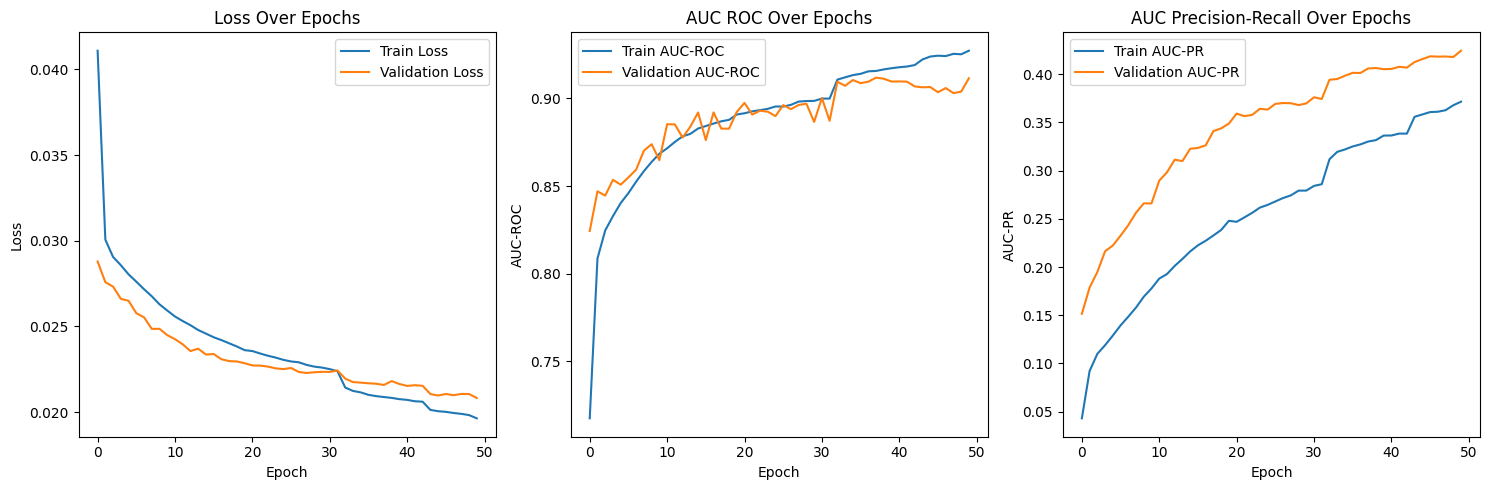

In [ ]:
# Train model
model_mf = mt.train_model(X_train_mf, y_train_mf, X_val_mf, y_val_mf, 'molecular_function', MODEL_TYPE['mf'], NUM_HIDDEN['mf'], SIZE_HIDDEN['mf'], ACTIVATION['mf'], DROPOUT['mf'], LR['mf'], EPOCHS, BATCH_SIZE, ALPHA['mf'], set_seed=SEED)

##### biological_process

In [ ]:
# Model summary
bp_mlp = mt.build_model(X_train_bp.shape[1], y_train_bp.shape[1], 'biological_process', MODEL_TYPE['bp'], NUM_HIDDEN['bp'], SIZE_HIDDEN['bp'], ACTIVATION['bp'], DROPOUT['bp'], ALPHA['bp'], set_seed=SEED)
bp_mlp.summary()

Model: "biological_process_fixed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_0_batch_norm                   │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_0_dropout (Dropout)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_dense (Dense)                │ (None, 300)                 │         307,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_dropout (Dropout)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_dense (Dense)                │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_dropout (Dropout)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_dense (Dense)                │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_dropout (Dropout)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_dense (Dense)                │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_dropout (Dropout)            │ (None, 300)                 │              

 Total params: 1,583,883 (6.04 MB)

 Trainable params: 1,575,835 (6.01 MB)

 Non-trainable params: 8,048 (31.44 KB)

          Model Configuration           
Aspect:               biological_process
Model Type:           fixed
Hidden Layers:        10
Units Per Layer:      300
Dropout:              0.3
Activation:           leaky_relu
Leaky ReLU Alpha:     0.05
Learning Rate:        0.01
Epoch 1/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step - auc-pr: 0.0346 - auc-roc: 0.6234 - binary_accuracy: 0.9658 - loss: 0.1050 - precision: 0.2694 - recall: 0.1223 - val_auc-pr: 0.0843 - val_auc-roc: 0.7842 - val_binary_accuracy: 0.9806 - val_loss: 0.0686 - val_precision: 0.6763 - val_recall: 0.1570 - learning_rate: 0.0100
Epoch 2/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - auc-pr: 0.0591 - auc-roc: 0.7336 - binary_accuracy: 0.9800 - loss: 0.0722 - precision: 0.6654 - recall: 0.1348 - val_auc-pr: 0.0910 - val_auc-roc: 0.7987 - val_binary_accuracy: 0.9805 - val_loss: 0.0687 - val_precision: 0.6277 - val_recall: 0.1866 - learning_rate: 0.0100
Epoch 3/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - auc-pr: 0.

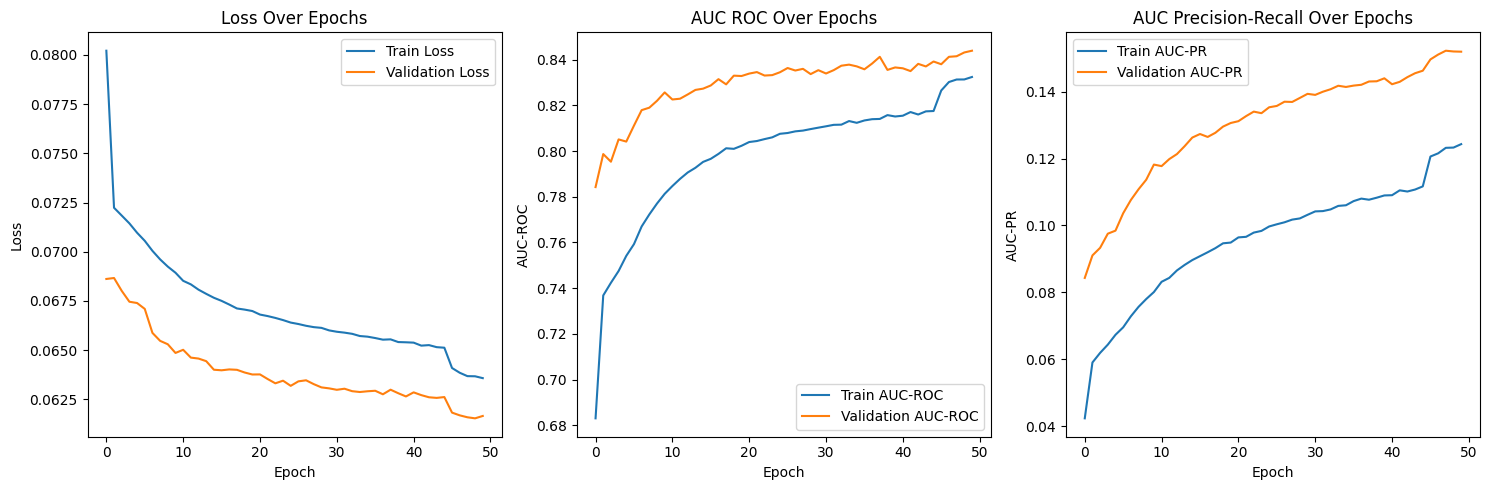

In [ ]:
# Train model
model_bp = mt.train_model(X_train_bp, y_train_bp, X_val_bp, y_val_bp, 'biological_process', MODEL_TYPE['bp'], NUM_HIDDEN['bp'], SIZE_HIDDEN['bp'], ACTIVATION['bp'], DROPOUT['bp'], LR['bp'], EPOCHS, BATCH_SIZE, ALPHA['bp'], set_seed=SEED)

##### cellular_component

In [ ]:
# Model summary
cc_mlp = mt.build_model(X_train_cc.shape[1], y_train_cc.shape[1], 'cellular_component', MODEL_TYPE['cc'], NUM_HIDDEN['cc'], SIZE_HIDDEN['cc'], ACTIVATION['cc'], DROPOUT['cc'], 0.05, set_seed=SEED)
cc_mlp.summary()

Model: "cellular_component_fixed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_0_batch_norm                   │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_0_dropout (Dropout)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_dense (Dense)                │ (None, 300)                 │         307,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_1_dropout (Dropout)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_dense (Dense)                │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_2_dropout (Dropout)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_dense (Dense)                │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_3_dropout (Dropout)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_dense (Dense)                │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_leaky_relu (LeakyReLU)       │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_batch_norm                   │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_4_dropout (Dropout)            │ (None, 300)                 │              

 Total params: 1,340,374 (5.11 MB)

 Trainable params: 1,332,326 (5.08 MB)

 Non-trainable params: 8,048 (31.44 KB)

          Model Configuration           
Aspect:               cellular_component
Model Type:           fixed
Hidden Layers:        10
Units Per Layer:      300
Dropout:              0.2
Activation:           leaky_relu
Leaky ReLU Alpha:     0.05
Learning Rate:        0.01
Epoch 1/50
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - auc-pr: 0.0345 - auc-roc: 0.6294 - binary_accuracy: 0.9737 - loss: 0.0706 - precision: 0.5107 - recall: 0.4597 - val_auc-pr: 0.1022 - val_auc-roc: 0.7753 - val_binary_accuracy: 0.9880 - val_loss: 0.0390 - val_precision: 0.7961 - val_recall: 0.5141 - learning_rate: 0.0100
Epoch 2/50
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - auc-pr: 0.0686 - auc-roc: 0.7357 - binary_accuracy: 0.9878 - loss: 0.0400 - precision: 0.7982 - recall: 0.4908 - val_auc-pr: 0.1208 - val_auc-roc: 0.8068 - val_binary_accuracy: 0.9881 - val_loss: 0.0385 - val_precision: 0.7855 - val_recall: 0.5313 - learning_rate: 0.0100
Epoch 3/50
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - auc-pr: 0.

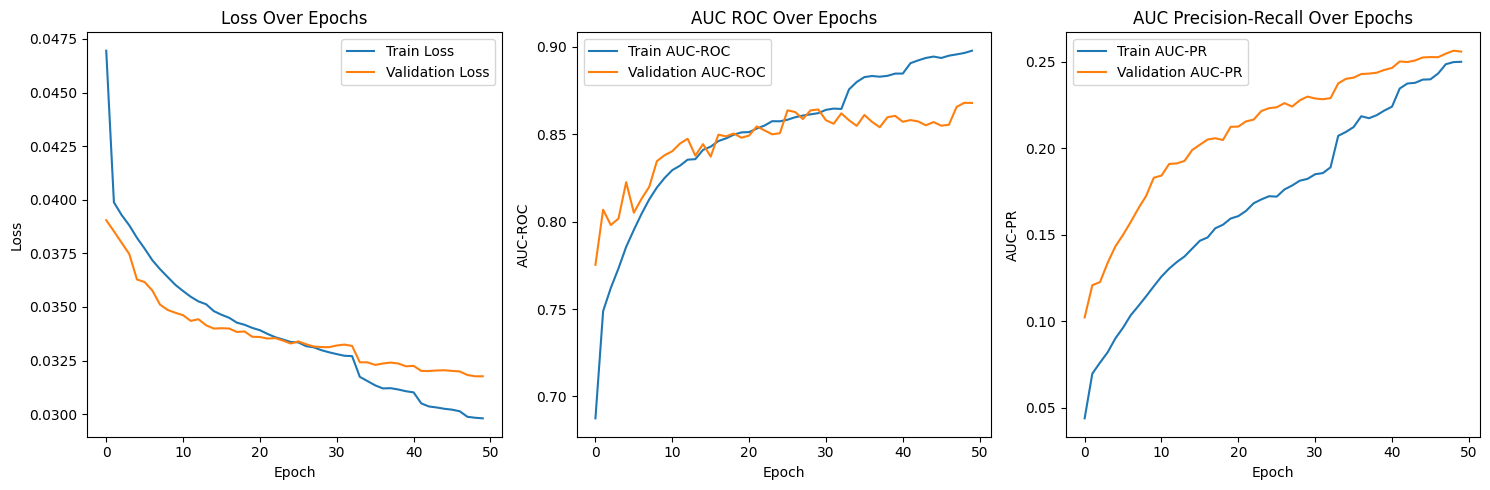

In [ ]:
# Train model
model_cc = mt.train_model(X_train_cc, y_train_cc, X_val_cc, y_val_cc, 'cellular_component', MODEL_TYPE['cc'], NUM_HIDDEN['cc'], SIZE_HIDDEN['cc'], ACTIVATION['cc'], DROPOUT['cc'], LR['cc'], EPOCHS, BATCH_SIZE, 0.05, set_seed=SEED)

## BLAST-based Scores

#### Data preprocessing

In [ ]:
# Encode GO terms using binary vectors
go_terms_dict = dp.process_go_terms(custom_train_set)
utils.display_dict_entries(go_terms_dict, n=5)
print(f"Unique GO terms: {len(go_terms_dict)}")

GO:0000003: [1 0 0 ... 0 0 0]
GO:0000030: [0 1 0 ... 0 0 0]
GO:0000041: [0 0 1 ... 0 0 0]
GO:0000049: [0 0 0 ... 0 0 0]
GO:0000070: [0 0 0 ... 0 0 0]
Unique GO terms: 3004


In [ ]:
# Filter BLAST matches and calculate weight based on e-value
blast = dp.process_blast_results(train_blast, custom_test_ids, evalue_threshold=1e-3, top_n=50, max_value=10)
print(f"Max weight: {blast['weight'].max()}")
print(f"Min weight: {blast['weight'].min():.3f}")
print(f"Max weight: {blast['weight'].max()}")

Max weight: 10.0
Min weight: 0.003
Max weight: 10.0


In [ ]:
# Extract BLAST target proteins' GO terms
target_go_terms = custom_train_set.groupby("protein_id")["go_term"].apply(list)
target_go_terms_dict = dp.create_target_go_terms_dict(target_go_terms)
utils.display_dict_entries(target_go_terms_dict, n=5)

A0A009IHW8: ['GO:0009056', 'GO:0006139', 'GO:0009987', 'GO:0019637', 'GO:1901575', 'GO:0006163', 'GO:0044248', 'GO:0008150', 'GO:0016798', 'GO:0003824', 'GO:0016799', 'GO:0016787', 'GO:0003674', 'GO:0072524', 'GO:0006796', 'GO:1901361', 'GO:0046496', 'GO:0055086', 'GO:0034641', 'GO:0044237', 'GO:0006753', 'GO:0006807', 'GO:0008152', 'GO:1901564', 'GO:0044281', 'GO:0019362', 'GO:0006725', 'GO:0044270', 'GO:0046434', 'GO:1901565', 'GO:0044238', 'GO:0046483', 'GO:0034655', 'GO:0009117', 'GO:0071704', 'GO:0046700', 'GO:1901360', 'GO:0019439', 'GO:0072521', 'GO:0006793']
A0A021WW32: ['GO:0007049', 'GO:0009891', 'GO:0005700', 'GO:0005705', 'GO:0031323', 'GO:0010604', 'GO:0009893', 'GO:0010556', 'GO:0031974', 'GO:0030182', 'GO:0032501', 'GO:0022402', 'GO:0032502', 'GO:0007275', 'GO:0048869', 'GO:0019222', 'GO:0031326', 'GO:0031981', 'GO:0043227', 'GO:0071695', 'GO:0007399', 'GO:0048666', 'GO:0048699', 'GO:0021700', 'GO:0048469', 'GO:0048468', 'GO:0048856', 'GO:0048731', 'GO:0022008', 'GO:0030

## Protein Function Prediction Tests

### MLP Predictions

In [ ]:
# Define model types and their corresponding GO term classes
classes = {
    'mf': classes_mf,
    'bp': classes_bp,
    'cc': classes_cc
}

# Load models and make predictions
models = {model: load_model(f"{MODELS_DIR}/model_{model}.keras") for model in model_types}

# Generate predictions and build DataFrames in one go
predictions = {}
for model in model_types:
    pred = models[model].predict(custom_test_embeddings)
    predictions[model] = mt.build_predictions_df(pred, custom_test_ids, classes[model], model)

# Concatenate predictions and sort the resulting DataFrame
pred_all_sorted = pd.concat(predictions.values()).sort_values(by=['protein_id', 'go_term'], ascending=[True, True])
pred_all_sorted.head()

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


,protein_id,aspect,go_term,prediction
1451312,A0A060W1Y7,bp,GO:0000003,0.114979
818864,A0A060W1Y7,mf,GO:0000030,0.000003
1451313,A0A060W1Y7,bp,GO:0000041,0.000518
818865,A0A060W1Y7,mf,GO:0000049,0.000028
1451314,A0A060W1Y7,bp,GO:0000070,0.000361


### BLAST-based Predictions

In [ ]:
# Calculate BLAST-based GO term scores
blast_based_scores = bbs.calculate_blast_based_scores(custom_test_ids, blast, go_terms_dict, target_go_terms_dict, n_go_terms=len(go_terms_dict), scores_init=-3.0)

### Combined Predictions

In [ ]:
# Combine predictions at different levels of influence of the MLP model
alpha_levels = np.arange(0.0, 1.1, 0.1).round(1).tolist()

predictions = {}
for alpha in alpha_levels:
    predictions[str(alpha)] = ensemble.update_predictions(pred_all_sorted, blast_based_scores, alpha=alpha)

### Create submission DataFrames and .tsv file for evaluation

In [ ]:
submissions = {}
for df in predictions:
  # Process each predictions dataframe
  mf = dp.process_predictions(predictions[df], 'mf', threshold=0.2, top_n=500)
  bp = dp.process_predictions(predictions[df], 'bp', threshold=0.2, top_n=500)
  cc = dp.process_predictions(predictions[df], 'cc', threshold=0.2, top_n=500)

  # Combine and sort the processed dataframes
  combined_df = pd.concat([
      mf,
      bp,
      cc
  ])

  # Create final submission DataFrame
  submissions[df] = combined_df.sort_values(by=['protein_id', 'aspect']).drop(columns=['aspect'])

  # Save to .tsv
  file_path = f"{EVALUATIONS_DIR}/test-alpha-{df}/predictions/submission_{df}.tsv"
  submissions[df].to_csv(file_path, sep='\t', index=False, header=False)

## Protein Function Prediction on the Original Test Set

### MLP Predictions

#### Data preprocessing

In [ ]:
# Get training set GO term labels
_, _, train_classes_mf = dp.prepare_features_and_labels('molecular_function', train_mf, train_embeddings, train_ids)
_, _, train_classes_bp = dp.prepare_features_and_labels('biological_process', train_bp, train_embeddings, train_ids)
_, _, train_classes_cc = dp.prepare_features_and_labels('cellular_component', train_cc, train_embeddings, train_ids)

Preparing molecular_function features and labels
Preparing biological_process features and labels
Preparing cellular_component features and labels


#### Prediction

In [ ]:
# Define model types and their corresponding GO term classes
train_classes = {
    'mf': train_classes_mf,
    'bp': train_classes_bp,
    'cc': train_classes_cc
}

# Load models and make predictions
test_models = {model: load_model(f"{MODELS_DIR}/model_{model}.keras") for model in model_types}

# Generate predictions and build DataFrames in one go
test_predictions = {}
for model in model_types:
    pred = test_models[model].predict(test_embeddings)
    test_predictions[model] = mt.build_predictions_df(pred, test_ids, train_classes[model], model)

# Concatenate predictions and sort the resulting DataFrame
test_pred_all_sorted = pd.concat(test_predictions.values()).sort_values(by=['protein_id', 'go_term'], ascending=[True, True])
test_pred_all_sorted.head()

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


,protein_id,aspect,go_term,prediction
0,A0A0B4JCV4,bp,GO:0000003,4.839781e-01
0,A0A0B4JCV4,mf,GO:0000030,1.762782e-10
1,A0A0B4JCV4,bp,GO:0000041,3.262438e-04
1,A0A0B4JCV4,mf,GO:0000049,6.956342e-05
2,A0A0B4JCV4,bp,GO:0000070,2.544723e-01


### BLAST-based Predictions

#### Data Preprocessing

In [ ]:
# Encode GO terms using binary vectors
test_go_terms_dict = dp.process_go_terms(train_set)
utils.display_dict_entries(test_go_terms_dict, n=5)
print(f"Unique GO terms: {len(test_go_terms_dict)}")

GO:0000003: [1 0 0 ... 0 0 0]
GO:0000030: [0 1 0 ... 0 0 0]
GO:0000041: [0 0 1 ... 0 0 0]
GO:0000049: [0 0 0 ... 0 0 0]
GO:0000070: [0 0 0 ... 0 0 0]
Unique GO terms: 3004


In [ ]:
# Filter BLAST matches and calculate weight based on e-value
final_blast = dp.process_blast_results(test_blast, test_ids, evalue_threshold=1e-3, top_n=50, max_value=10)
print(f"Max weight: {final_blast['weight'].max()}")
print(f"Min weight: {final_blast['weight'].min():.3f}")
print(f"Max weight: {final_blast['weight'].max()}")

Max weight: 10.0
Min weight: 0.004
Max weight: 10.0


In [ ]:
# Extract BLAST target proteins' GO terms
test_target_go_terms = train_set.groupby("protein_id")["go_term"].apply(list)
test_target_go_terms_dict = dp.create_target_go_terms_dict(test_target_go_terms)
utils.display_dict_entries(test_target_go_terms_dict, n=5)

A0A009IHW8: ['GO:0009056', 'GO:0006139', 'GO:0009987', 'GO:0019637', 'GO:1901575', 'GO:0006163', 'GO:0044248', 'GO:0008150', 'GO:0016798', 'GO:0003824', 'GO:0016799', 'GO:0016787', 'GO:0003674', 'GO:0072524', 'GO:0006796', 'GO:1901361', 'GO:0046496', 'GO:0055086', 'GO:0034641', 'GO:0044237', 'GO:0006753', 'GO:0006807', 'GO:0008152', 'GO:1901564', 'GO:0044281', 'GO:0019362', 'GO:0006725', 'GO:0044270', 'GO:0046434', 'GO:1901565', 'GO:0044238', 'GO:0046483', 'GO:0034655', 'GO:0009117', 'GO:0071704', 'GO:0046700', 'GO:1901360', 'GO:0019439', 'GO:0072521', 'GO:0006793']
A0A021WW32: ['GO:0007049', 'GO:0009891', 'GO:0005700', 'GO:0005705', 'GO:0031323', 'GO:0010604', 'GO:0009893', 'GO:0010556', 'GO:0031974', 'GO:0030182', 'GO:0032501', 'GO:0022402', 'GO:0032502', 'GO:0007275', 'GO:0048869', 'GO:0019222', 'GO:0031326', 'GO:0031981', 'GO:0043227', 'GO:0071695', 'GO:0007399', 'GO:0048666', 'GO:0048699', 'GO:0021700', 'GO:0048469', 'GO:0048468', 'GO:0048856', 'GO:0048731', 'GO:0022008', 'GO:0030

#### Prediction

In [ ]:
# Calculate BLAST-based GO term scores
test_blast_based_scores = bbs.calculate_blast_based_scores(test_ids, final_blast, test_go_terms_dict, test_target_go_terms_dict, n_go_terms=len(test_go_terms_dict), scores_init=-3.0)

### Combined Predictions

In [ ]:
# Set MLP weight (alpha) on the final predictions and combine the two methods
alpha = 0.2
test_predictions = ensemble.update_predictions(test_pred_all_sorted, test_blast_based_scores, alpha=alpha)

### Create submission DataFrames and .tsv file for evaluation

In [ ]:
test_mf = dp.process_predictions(test_predictions, 'mf', threshold=0.2, top_n=500)
test_bp = dp.process_predictions(test_predictions, 'bp', threshold=0.2, top_n=500)
test_cc = dp.process_predictions(test_predictions, 'cc', threshold=0.2, top_n=500)

# Combine and sort the processed dataframes
test_combined_df = pd.concat([
    test_mf,
    test_bp,
    test_cc
])

# Create final submission DataFrame
submission = test_combined_df.sort_values(by=['protein_id', 'aspect']).drop(columns=['aspect'])

# Save to .tsv
file_path = f"{RESULTS_DIR}/submission/submission.tsv"
submission.to_csv(file_path, sep='\t', index=False, header=False)